In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
# %matplotlib inline

In [2]:
from scipy.stats import cauchy
import scipy.stats as stats 
import arviz as az
from JSAnimation import IPython_display
import pymc3 as pm
import theano as thea
import theano.tensor as T 
%matplotlib inline

In [3]:
def Cauchy(x, a, t0, sigma,b, y_intercept):
    
    return (-1*a / ( 1.0 + (abs( (x-t0)/sigma ))**(2.0*b) ))+y_intercept 

In [4]:
np.random.seed(23)

In [6]:
df = pd.read_excel('./../Data/lc.xlsx')

In [7]:
# Choosing a filter from the list of filters: [V , R, B]
filt = 'V'

#selecting a higher and lower limit for the fraction of the light curve including the minima
low_lim = 150
up_lim =200

#Selecting the portion of the light curve including the minima
x = df['time_'+filt].values[low_lim:up_lim]-2.4588252e6
y = df['rel_f_'+filt].values[low_lim:up_lim]
yerr = df['rel_f_'+filt+'_err'].values[low_lim:up_lim] 

Text(0, 0.5, 'Relative Flux')

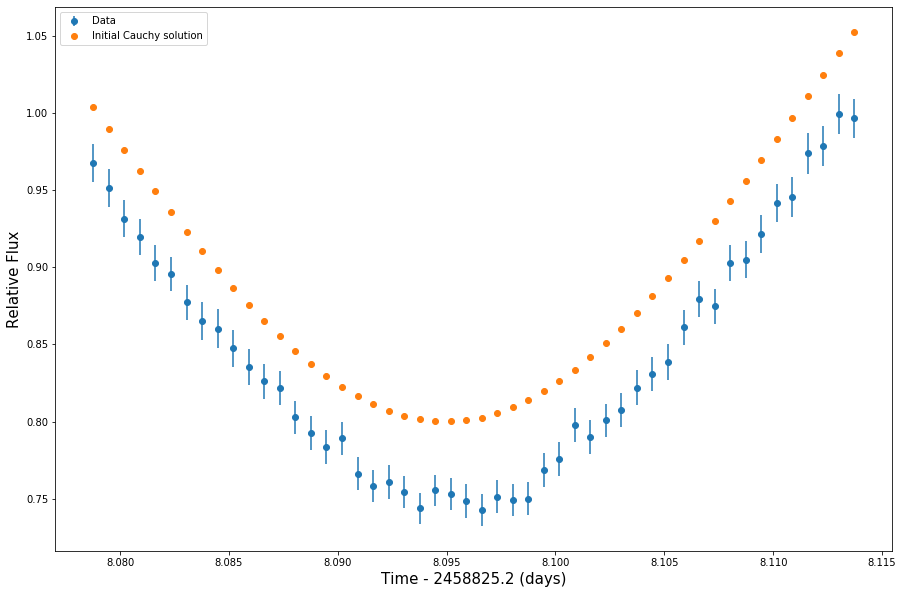

In [12]:
#Plotting the minima along with an approximate Cauchy function
fig = plt.figure(figsize=(15,10))

plt.errorbar(x,y, yerr, fmt='o', label = 'Data')
plt.errorbar(x,Cauchy(x, 0.9, 8.095, 0.03,1, 1.7), fmt='o', label = 'Initial Cauchy solution')


plt.legend()
plt.xlabel('Time - 2458825.2 (days)', size = 15)
plt.ylabel('Relative Flux', size =15)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_intercept, b, sigma, t0, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 502 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.176966853710045, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less usefu

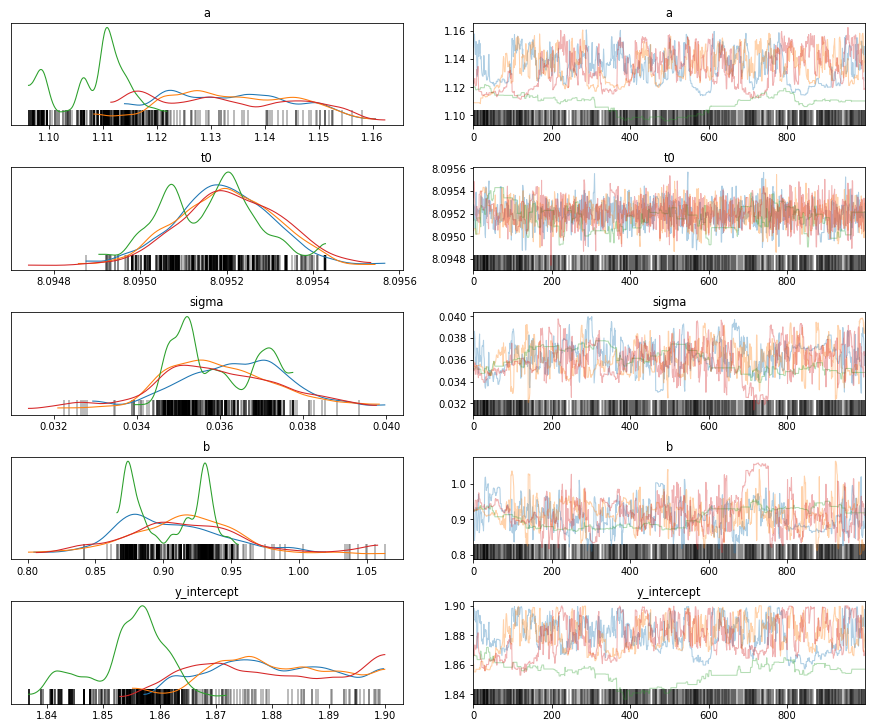

In [13]:
nsample = 1000

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    
    # Define priors
    a = pm.Uniform('a', lower=0.8, upper=2)
    t0 = pm.Uniform('t0', lower=8.09, upper=8.1)
    sigma = pm.Uniform('sigma', lower=0.02, upper=0.04)
    b = pm.Uniform('b', lower=0.8, upper=1.1)
    y_i = pm.Uniform('y_intercept', lower = 1.5, upper = 1.9)

    # Define likelihood
    likelihood = pm.Normal('y', mu= (-1*a / ( 1.0 + (abs( (x-t0)/sigma ))**(2.0*b) ))+y_i , \
                        sd=yerr, observed=y)   
    # Inference
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True) # run with 4 cores

az.plot_trace(trace);

In [14]:
az.summary(trace, round_to=5)

/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.12716,0.01528,1.09860,1.15290,0.00564,0.00416,7.34401,7.34401,7.33709,21.95084,1.51061
t0,8.09519,0.00011,8.09498,8.09540,0.00001,0.00001,203.32473,203.32218,207.81486,568.89636,1.01835
sigma,0.03608,0.00136,0.03387,0.03901,0.00013,0.00009,108.69202,108.69202,106.67234,147.09011,1.04634
b,0.91148,0.04080,0.83541,0.99051,0.00432,0.00306,89.27517,89.27517,81.56585,127.06110,1.05582
y_intercept,1.87327,0.01515,1.85089,1.89997,0.00567,0.00419,7.13844,7.13844,7.37673,22.00000,1.51018


In [15]:
az.summary(trace, round_to=5)['mean'].t0+2.4588252e6

/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


2458833.29519

Text(0, 0.5, 'Relative Flux')

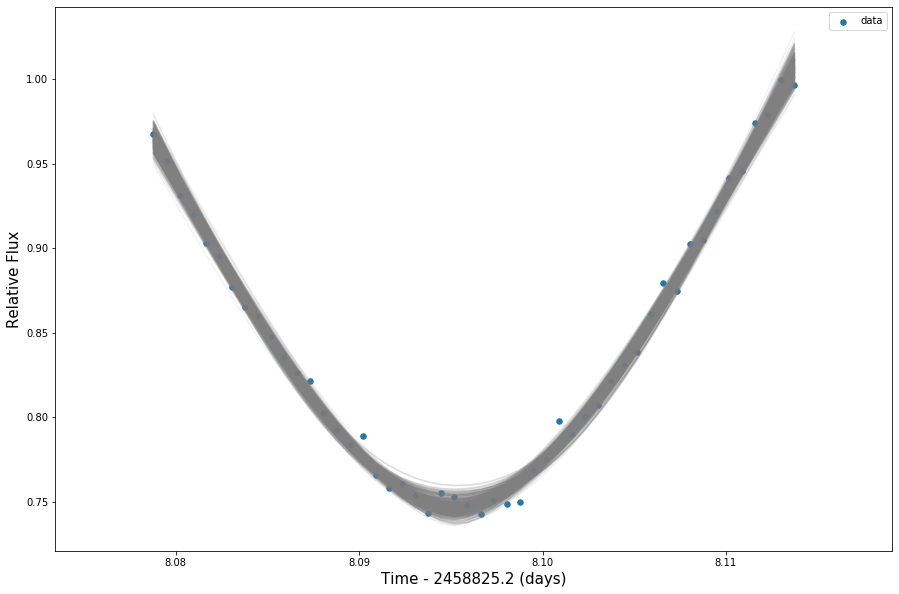

In [16]:
### Plot the predictive posterior samples

fig = plt.figure(figsize=(15,10))


plt.scatter(x, y, s=30, label='data')
for a_, b_, c_, d_, e_ in zip(trace['a'][-500:], trace['t0'][-500:], trace['sigma'][-500:],trace['b'][-500:], trace['y_intercept'][-500:]):
    plt.plot(x, (-1*a_ / ( 1.0 + (abs( (x-b_)/c_ ))**(2.0*d_) ))+e_, c='gray', alpha=0.1)
    

plt.legend()
plt.xlabel('Time - 2458825.2 (days)', size = 15)
plt.ylabel('Relative Flux', size =15)